# Insight One: 
    


In [1]:
import sys

from dotenv import find_dotenv, dotenv_values
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

config = dotenv_values(find_dotenv(".env"))

sys.path.append("..")
from src.make_data import build_metrics, filter_tv_shows
from src.plots import plot_median_movie_lift_over_time, plot_median_movie_score_over_time, colors_zebra_interview

sys.tracebacklimit = 0 # easier to see problems
plt.rcParams["figure.figsize"] = (16, 12)

In [2]:
df = pd.read_csv(config["cleaned_data_path"])
print(df.shape)

df = build_metrics(df)

# only movies since can't separate tv shows from movies
df = filter_tv_shows(df)

(4920, 30)
shape - (4920, 35), columns added - ['budget_log', 'gross_log', 'lift', 'profit', 'ROI']


<Axes: >

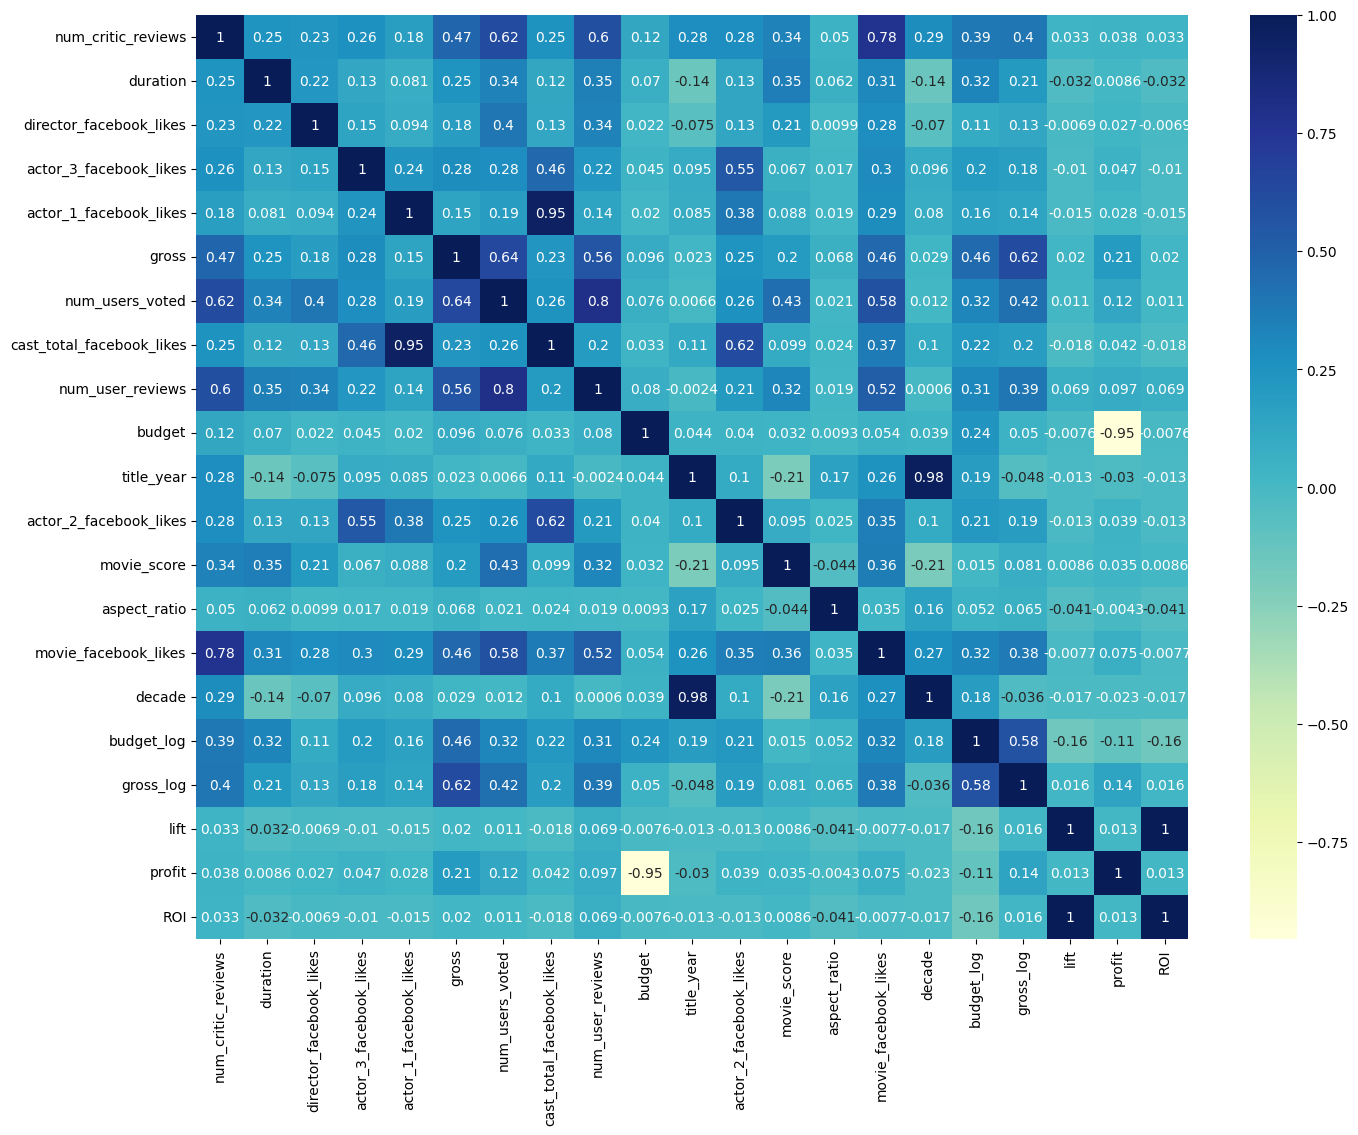

In [3]:
# test correlations
df_nums = df.select_dtypes(np.number)
df_nums = df_nums.loc[df_nums["cast_total_facebook_likes"].notnull(),]

sns.heatmap(df_nums.corr(), annot = True, cmap='YlGnBu')

In [8]:
df = df.assign(franchise_ind = np.where(df["movie_franchise"].notnull(), 1, 0))



In [9]:
df.head(1).T

,0
color,Color
director_name,Frank Darabont
num_critic_reviews,199.0
duration,142.0
director_facebook_likes,NaN
actor_3_facebook_likes,461.0
actor_2_name,Jeffrey DeMunn
actor_1_facebook_likes,11000.0
gross,28341469.0
genres,Crime|Drama


## Looking at the Franchises

In [10]:
colors_zebra_interview = {
    "Vibrant Purple": "#574cfa",
    "Dark Charcoal": "#070e15",
     "Medium Gray": "#c8c8c8",
    "Deep Blue": "#1b1d4e",
    "Royal Blue": "#2f2d87",
    "Light Gray": "#c7c7c7",
    "Light Silver": "#cfcfcf",
    "Soft Gray": "#d0d0d0",
    "Warm Gray": "#cecece"
} # taken from attachments given in interview, used chatGPT to get hexidecimal 

In [11]:
df["movie_franchise"].value_counts().reset_index().head(5)["movie_franchise"].to_list()

['Star Wars',
 'Mission',
 'Star Trek',
 'Pirates of the Caribbean',
 'Resident Evil']

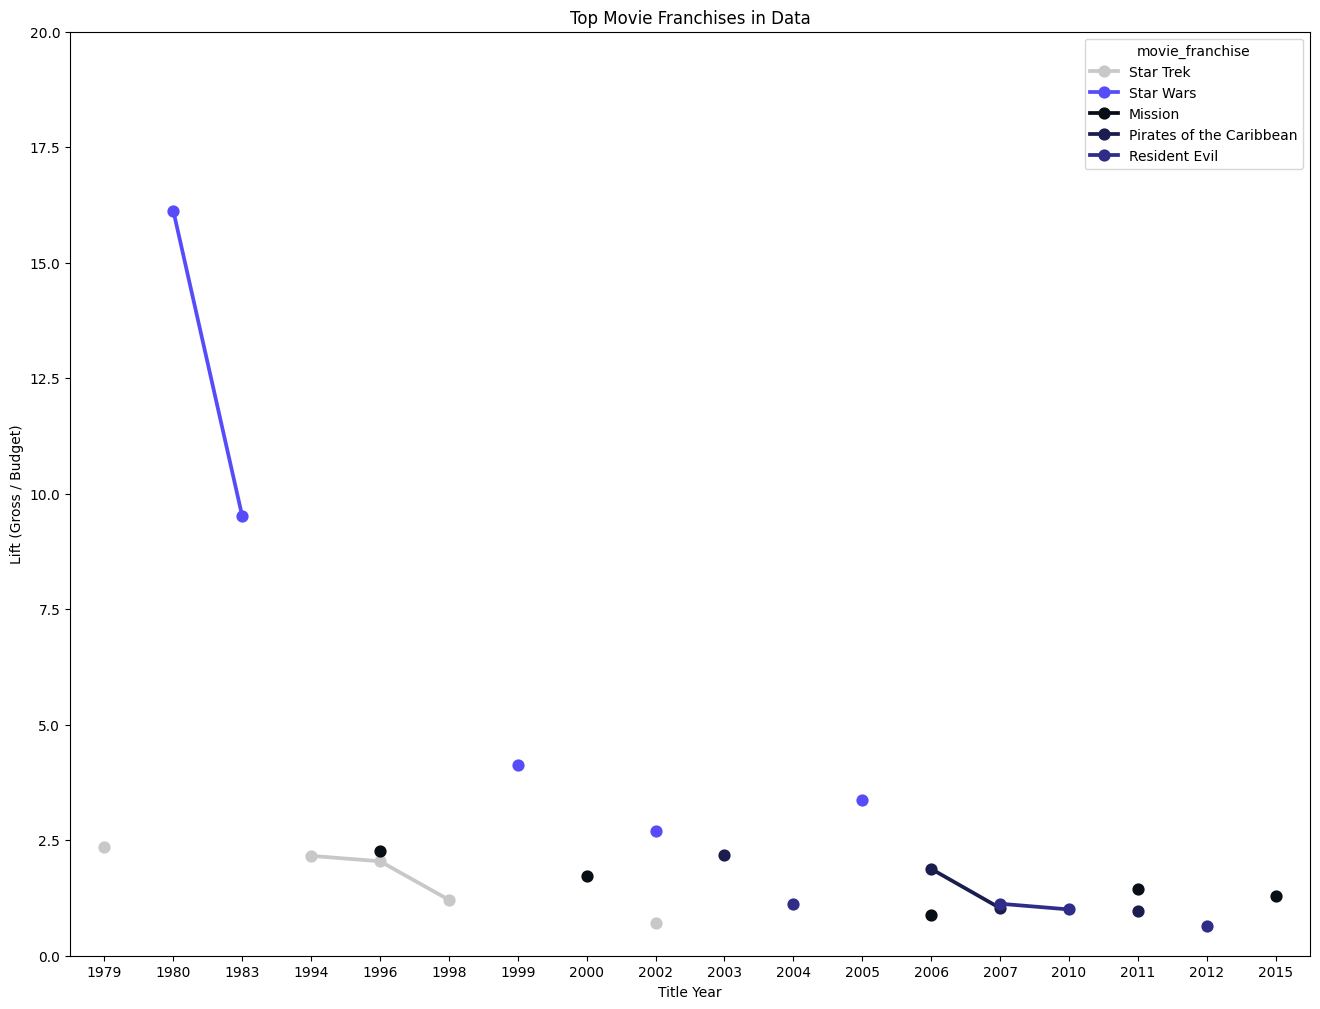

In [17]:

# make sure to not 1st star wars was a 40x in 1977:
top_ = df["movie_franchise"].value_counts().reset_index().head(5)["movie_franchise"].to_list()

df["title_year"] = df.title_year.astype(int)
new_pal = {}

for k, v in zip(top_, colors_zebra_interview.items()):
    new_pal[k] = v[1]

df_select_franchise = df.loc[df["movie_franchise"].isin(top_ten_)]

tmp = df_select_franchise.loc[df_select_franchise["title_year"] > 1977]

fig, ax = plt.subplots()

sns.pointplot(data=tmp, x = "title_year", y= "lift", hue = "movie_franchise", palette=new_pal).set(title = "Top Movie Franchises in Data",
 xlabel = "Title Year", ylabel = "Lift (Gross / Budget)")

ax.set_ylim(0, 20)
# fig.suptitle("We can't expect to recapture the 40x in Star Wars 1 in 1977")

plt.savefig("..//plots/Top_Franchises.png")

plt.show()

In [218]:
# different graph connected

# fig, ax = plt.subplots()

# df["title_year"] = df.title_year.astype(int)

# star_wars = df.loc[df["movie_franchise"] == "Star Wars"]
# mission = df.loc[df["movie_franchise"] == "Mission"]
# star_trek = df.loc[df["movie_franchise"] == "Star Trek"]
# x_men = df.loc[df["movie_franchise"] == "X-Men"]

# sns.pointplot(data = star_wars, x = "title_year", y= "lift", label = "Star Wars", color = colors_zebra_interview["Deep Blue"], ax = ax).set_title("Should We Make Another Star Wars?")
# sns.pointplot(data = star_trek, x = "title_year", y= "lift", label = "Star Trek", color = colors_zebra_interview["Dark Charcoal"], ax = ax)
# sns.pointplot(data = mission, x = "title_year", y= "lift", label = "Mission Impossible", color = colors_zebra_interview["Vibrant Purple"], ax = ax)
# sns.pointplot(data = x_men, x = "title_year", y= "lift", label = "Mission Impossible", color = colors_zebra_interview["Royal Blue"], ax = ax)

# years = pd.concat([star_wars['title_year'], mission['title_year'], star_trek['title_year'], x_men['title_year']]).astype(int).tolist()


## Looking at Break out Hits

* these are the ones that are 10x +

In [34]:
df= df.assign(break_out_hits_ind = np.where(df["lift"] > 10, "yes", "no"))

tbl = df.groupby("break_out_hits_ind").agg(
        n = ("movie_title", "count"),
        median_score = ("movie_score", "median"),
        avg_users_voted = ("num_users_voted", "median"),
        median_facebook_likes = ('cast_total_facebook_likes', "median"),
        median_director_likes = ('director_facebook_likes', "median"),
        median_actor1_likes = ('actor_1_facebook_likes', "median"),
        median_actor2_likes = ('actor_2_facebook_likes', "median"),
        median_actor3_likes = ('actor_3_facebook_likes', "median"),
        median_duration = ('duration', "median"),
        median_title_year = ("title_year", "median"),
        num_users_voted = ("num_users_voted", "sum")
    ).round(2).astype(int)


tbl.T

break_out_hits_ind,no,yes
n,4655,149
median_score,6,7
avg_users_voted,33067,72443
median_facebook_likes,3161,1964
median_director_likes,80,102
median_actor1_likes,1000,816
median_actor2_likes,608,398
median_actor3_likes,383,249
median_duration,104,99
median_title_year,2005,1994


***

* looks like for this group people care more about the director than the actors
* shorter is better

In [ ]:
pd.options.display.max_rows = 999

df.loc[df["lift"] > 10].sort_values("lift")[["director_name", "title_year"]]

In [45]:
len(df["director_name"].unique())

2390

In [50]:
pd.options.display.max_rows = 999

tbl = df.loc[df["lift"] > 10].sort_values(["director_name", "title_year"])[["director_name", "title_year", "lift", "movie_title"]]

tbl

,director_name,title_year,lift,movie_title
2363,Adrian Lyne,1983,23.725000,Flashdance
1879,Adrian Lyne,1987,11.188978,Fatal Attraction
3348,Alex Kendrick,2006,101.746630,Facing the Giants
3080,Alex Kendrick,2008,66.902958,Fireproof
3167,Alex Kendrick,2011,17.261111,Courageous
155,Alfred Hitchcock,1960,39.655640,Psycho
760,Asghar Farhadi,2011,14.196984,A Separation
1536,Billy Bob Thornton,1996,27.500467,Sling Blade
2487,Bob Clark,1981,26.375000,Porky's
1940,Bradley Parker,2012,18.112929,Chernobyl Diaries


In [60]:
tbl["is_duplicate"] = df.duplicated(subset = "director_name", keep = False)

tbl.groupby("is_duplicate").agg(
    counts = ("is_duplicate", "count"),
    mean_year = ("title_year", "mean"),
    median_lift = ("lift", "median")
)

,counts,did_it_twice,mean_year,median_lift
is_duplicate,,,,
False,36,0,1989.611111,22.46946
True,113,113,1990.920354,18.04830


In [67]:
df["is_duplicate"] = df.duplicated(subset = "director_name", keep = False)

tbl = df.groupby("break_out_hits_ind").agg(
    counts = ("is_duplicate", "count"),
    director_twice = ("is_duplicate", "sum"),
    mean_year = ("title_year", "mean"),
    median_lift = ("lift", "median")
)

tbl["prop"] = tbl["director_twice"] /tbl["counts"]

tbl


,counts,director_twice,mean_year,median_lift,prop
break_out_hits_ind,,,,,
no,4655,3173,2002.819549,1.012800,0.681633
yes,149,113,1990.604027,19.132379,0.758389


In [ ]:
## pg t test